In [1]:
from pathlib import Path
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
import copy
import pickle

# Project modules
from lib.Stokes import Stokes
from functions.plot_data import plot_data
from functions.plot_angle_gradient import plot_angle_gradient

In [2]:
# Open data files
from functions.load_pickles import load_pickles
stokes_list, derived = load_pickles()

Loading Stokes data from file generated/objects/stokes.pickle
Loading Derived data from file generated/objects/derived.pickle


In [3]:
# Extract each Stokes parameter into dictionary, to make it easier to work with
I = stokes_list['I']
Q = stokes_list['Q']
U = stokes_list['U']
V = stokes_list['V']

In [4]:
# Constants
C = 4.67e-13 # TODO: where is this constant from? Sara's email (and PDF) 29/08
lambda0  = [6301.51*1e-8, 6302.50*1e-8]   # Angstroms to cm
gbar     = [1.669, 2.487] # Lozitsky

Noise level = 0.0033832064364105463


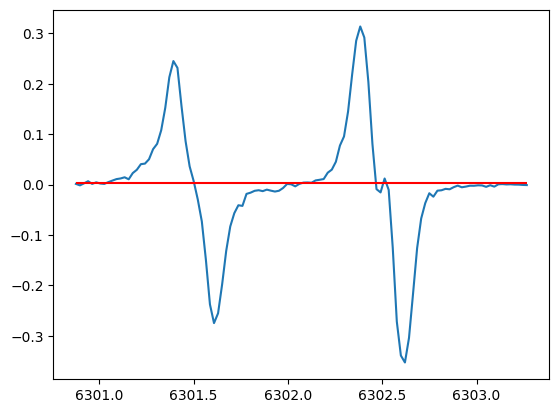

In [5]:
def noise_level(a):
    a = np.asanyarray(a)
    sd = a.std(ddof=1)
    return sd

# Example spectrum noise level
spectrum = copy.copy(V.data_n[300,300,:])
sd = noise_level(spectrum[90:])
print(f'Noise level = {sd}')
plt.plot(V.wave_array, spectrum, linestyle='-')
plt.hlines(sd, V.wave_array[0], V.wave_array[-1], color='red')

In [25]:
# Calculate delta lambda_B for each pixel, for each line

dlB = np.zeros(I.data.shape)[:,:,:2].astype(float)
dlB_binary = np.zeros(I.data.shape)[:,:,:2].astype(float)
margin = 3.5
verbose = 0

for i in range(0, np.shape(V.data_n)[0]):

    # Read out every 50 rows
    if np.mod(i,50) == 0:
        print(f'Row {i} of {np.shape(V.data_n)[0]}')

    for j in range(0, np.shape(V.data_n)[1]):
        if (verbose):
            print(f'For pixel {i},{j}:')

        # Initialize variables
        peaks_p = [0, 0]
        peaks_n = [0, 0]

        # Get the spectrum for this pixel
        spectrum = copy.copy(V.data_n[i,j,:])

        # Calculate noise level for spectrum region outside the spectral lines
        sd = noise_level(spectrum[90:])
        if (verbose):
            print(f'Noise level = {sd}')

        # First line
        peaks_p[0] = int(np.argmax(spectrum[:60])) if spectrum[:60].max() > margin*sd else None
        peaks_n[0] = int(np.argmin(spectrum[:60])) if spectrum[:60].min() < -margin*sd else None

        # # Second line
        peaks_p[1] = 60 + int(np.argmax(spectrum[60:])) if spectrum[60:].max() > margin*sd else None
        peaks_n[1] = 60 + int(np.argmin(spectrum[60:])) if spectrum[60:].min() < -margin*sd else None

        if (verbose):
            print(f'Peak positions: {peaks_p}, {peaks_n}')

        # If two peaks have been found for the first line, calculate dlB
        if peaks_p[0] is not None and peaks_n[0] is not None:
            dlB_binary[i, j, 0] = 1
            dlB[i, j, 0] = np.array(V.wave_array)[peaks_p[0]] - np.array(V.wave_array)[peaks_n[0]]

            if (verbose):
                plt.figure()
                plt.vlines(V.wave_array[peaks_n[0]], ymin=np.min(spectrum), ymax=np.max(spectrum), color='g', linestyle='--')
                plt.vlines(V.wave_array[peaks_p[0]], ymin=np.min(spectrum), ymax=np.max(spectrum), color='purple', linestyle='--')

                print(f'Peak 1 positive: {V.wave_array[peaks_p[0]]}')
                print(f'Peak 1 negative: {V.wave_array[peaks_n[0]]}')
                print(np.array(V.wave_array)[peaks_p[0]] - np.array(V.wave_array)[peaks_n[0]])
                print(f'Distance: {dlB[i, j, 0]:.6f} Angstrom')
        else:
            dlB[i, j, 0] = np.nan


        # If two peaks have been found for the second line, calculate dlB
        if peaks_p[1] is not None and peaks_n[1] is not None:
            dlB_binary[i, j, 1] = 1
            dlB[i, j, 1] = np.array(V.wave_array)[peaks_p[1]] - np.array(V.wave_array)[peaks_n[1]]

            if (verbose):
                plt.figure()
                plt.vlines(V.wave_array[peaks_n[1]], ymin=np.min(spectrum), ymax=np.max(spectrum), color='g', linestyle='--')
                plt.vlines(V.wave_array[peaks_p[1]], ymin=np.min(spectrum), ymax=np.max(spectrum), color='purple', linestyle='--')

                print(f'Peak 2 positive: {V.wave_array[peaks_p[1]]}')
                print(f'Peak 2 negative: {V.wave_array[peaks_n[1]]}')
                print(np.array(V.wave_array)[peaks_p[1]] - np.array(V.wave_array)[peaks_n[1]])
                print(f'Distance: {dlB[i, j, 1]:.6f} Angstrom')
        else:
            dlB[i, j, 1] = np.nan

        if (verbose):
            plt.hlines(margin*sd, V.wave_array[0], V.wave_array[-1], color='red', linestyle='--')
            plt.hlines(-margin*sd, V.wave_array[0], V.wave_array[-1], color='red', linestyle='--')
            plt.plot(V.wave_array, spectrum, linestyle='-', color='black')

Row 0 of 768
Row 50 of 768
Row 100 of 768
Row 150 of 768
Row 200 of 768
Row 250 of 768
Row 300 of 768
Row 350 of 768
Row 400 of 768
Row 450 of 768
Row 500 of 768
Row 550 of 768
Row 600 of 768
Row 650 of 768
Row 700 of 768
Row 750 of 768


In [ ]:
# Get absolute value of dlB TODO: confirm this is correct
# dlB = np.abs(dlB)

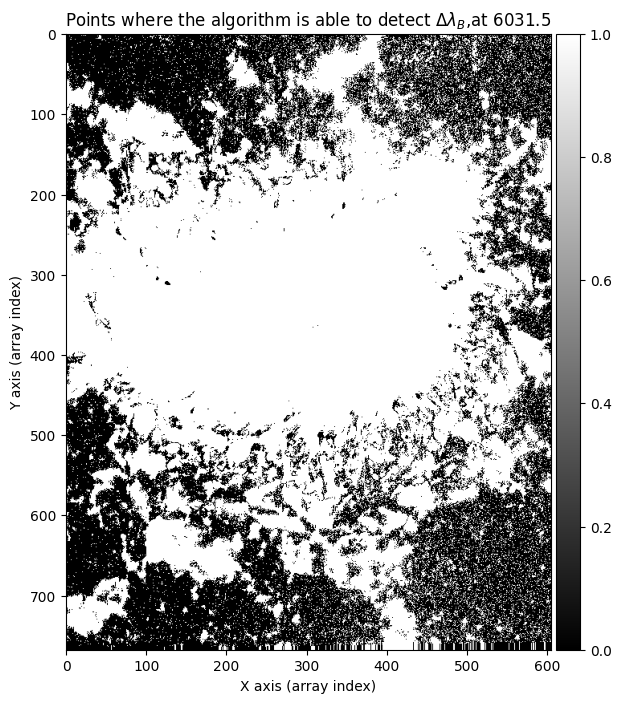

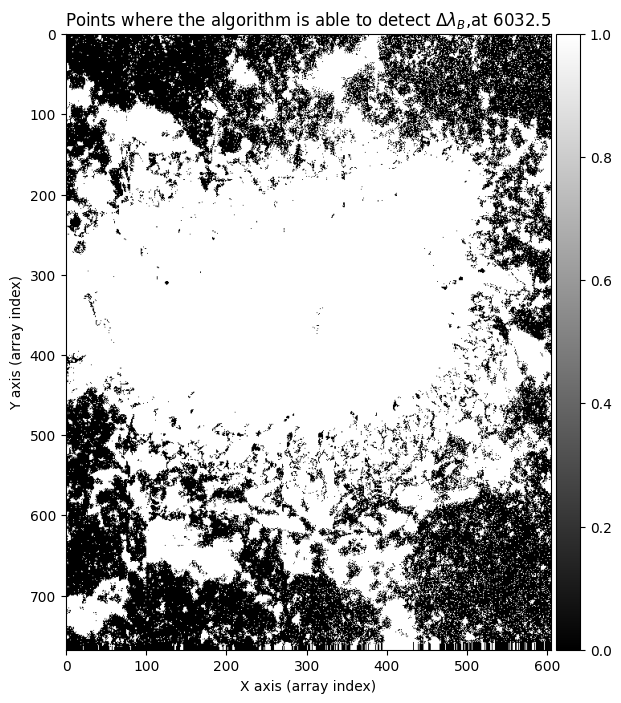

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Points where the algorithm is able to detect $\\Delta \\lambda _B$,at 6032.5'}, xlabel='X axis (array index)', ylabel='Y axis (array index)'>)

In [8]:
plot_data(dlB_binary[:,:,0], title=r"Points where the algorithm is able to detect $\Delta \lambda _B$,at 6031.5")
plot_data(dlB_binary[:,:,1], title=r"Points where the algorithm is able to detect $\Delta \lambda _B$,at 6032.5")

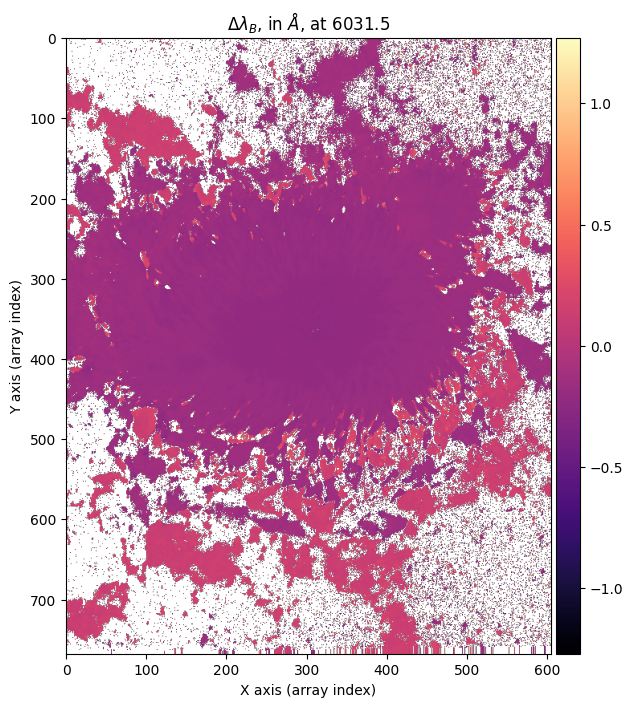

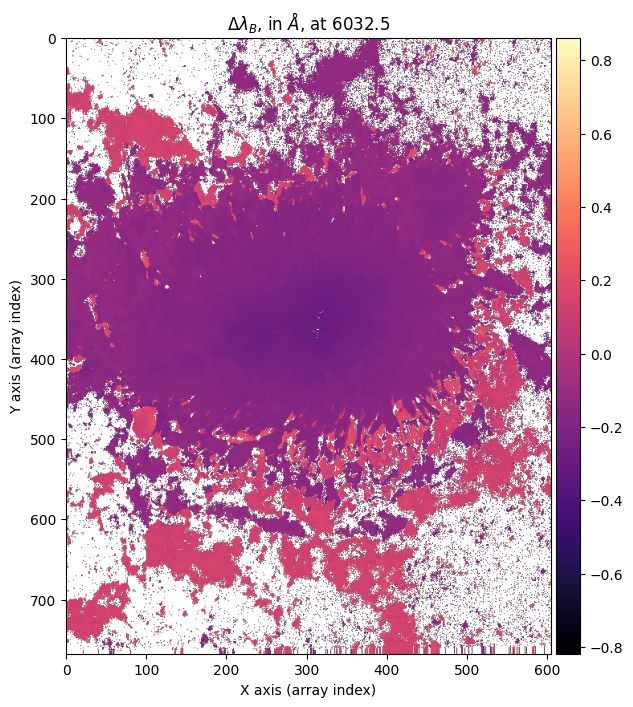

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': '$\\Delta \\lambda _B$, in $\\AA$, at 6032.5'}, xlabel='X axis (array index)', ylabel='Y axis (array index)'>)

In [31]:
plot_data(dlB[:,:,0], colourmap='magma', title=r"$\Delta \lambda _B$, in $\AA$, at 6031.5")
plot_data(dlB[:,:,1], colourmap='magma', title=r"$\Delta \lambda _B$, in $\AA$, at 6032.5")

In [26]:
# Calculate strong magnetic field
B_strong = dlB / (2 * C * np.array(lambda0)**2 * np.array(gbar))

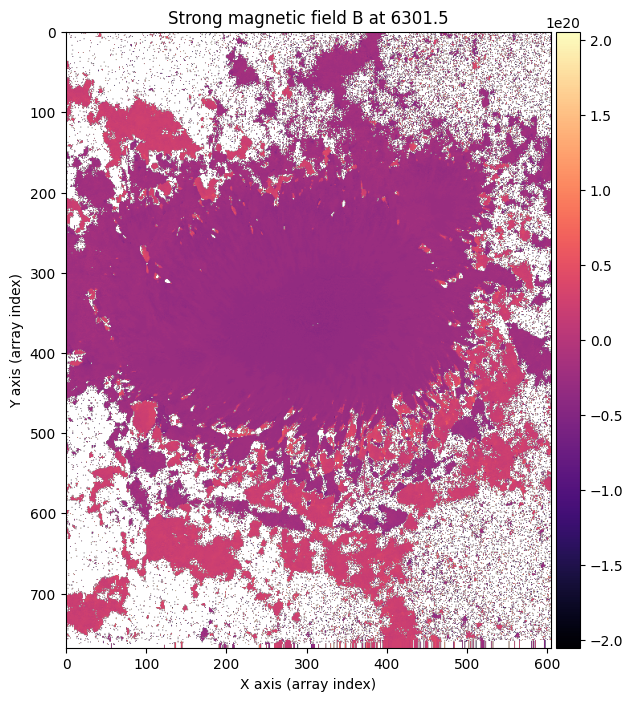

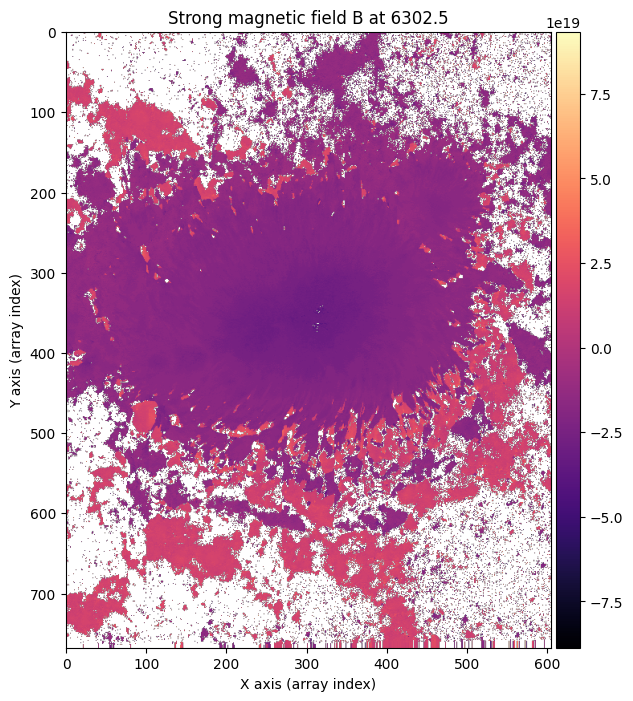

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Strong magnetic field B at 6302.5'}, xlabel='X axis (array index)', ylabel='Y axis (array index)'>)

In [29]:
plot_data(B_strong[:,:,0], colourmap='magma', title='Strong magnetic field B at 6301.5')
plot_data(B_strong[:,:,1], colourmap='magma', title='Strong magnetic field B at 6302.5' )

In [19]:
# Define function to sum data along the third axis (sum all wavelengths)
def sw(data):
    return np.sum(data, axis=2)

In [20]:
# Calculate inclination and azimuth angles from Q, U, V
chi_strong = np.arctan2(sw(U.data_n), sw(Q.data_n)) / 2

In [21]:
# Calculate inclination, per spectral line

line_cuttoff = 55 # index at which we divide the data, between the spectral lines
gamma_1 = np.arctan2(sw(Q.data_n[:,:,:line_cuttoff] + U.data_n[:,:,:line_cuttoff])**(1/4), sw(V.data_n[:,:,:line_cuttoff]))
gamma_2 = np.arctan2(sw(Q.data_n[:,:,line_cuttoff:] + U.data_n[:,:,line_cuttoff:])**(1/4), sw(V.data_n[:,:,line_cuttoff:]))

/tmp/ipykernel_7408/1178051554.py:4: RuntimeWarning: invalid value encountered in power
  gamma_1 = np.arctan2(sw(Q.data_n[:,:,:line_cuttoff] + U.data_n[:,:,:line_cuttoff])**(1/4), sw(V.data_n[:,:,:line_cuttoff]))
/tmp/ipykernel_7408/1178051554.py:5: RuntimeWarning: invalid value encountered in power
  gamma_2 = np.arctan2(sw(Q.data_n[:,:,line_cuttoff:] + U.data_n[:,:,line_cuttoff:])**(1/4), sw(V.data_n[:,:,line_cuttoff:]))


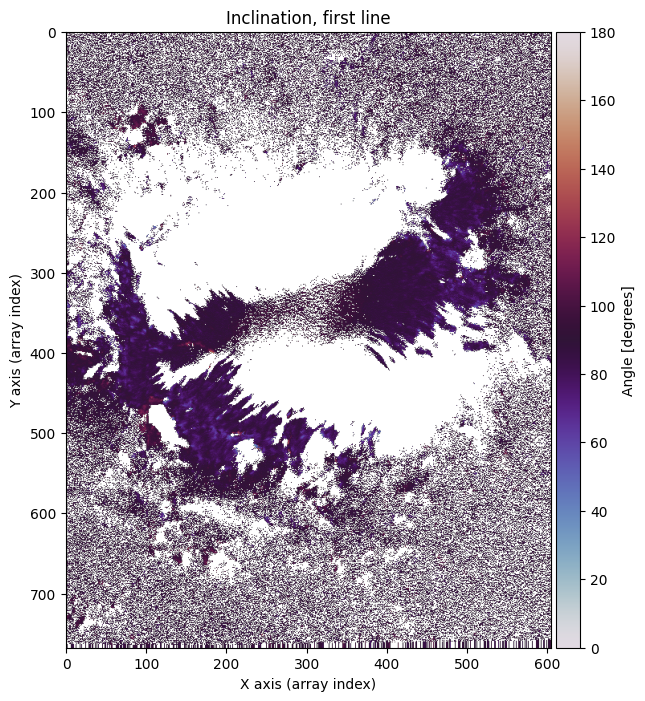

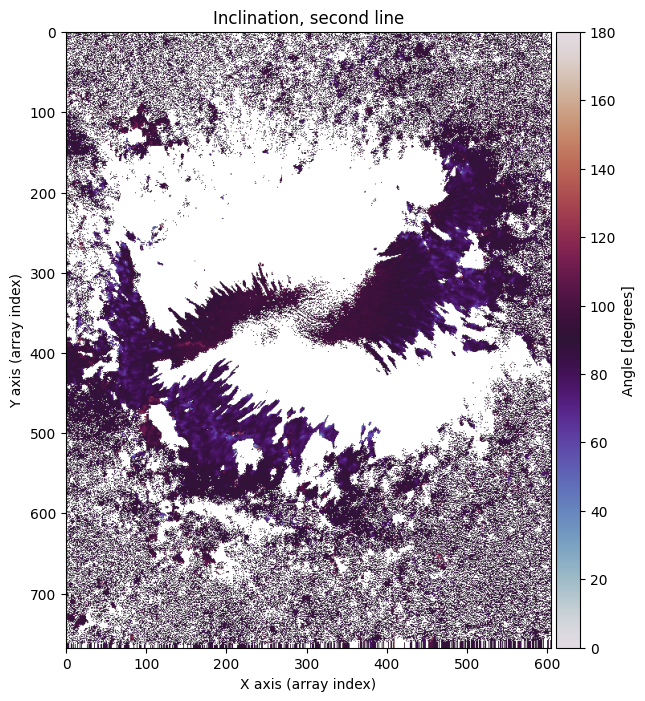

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Inclination, second line'}, xlabel='X axis (array index)', ylabel='Y axis (array index)'>)

In [22]:
plot_angle_gradient(gamma_1, title='Inclination, first line')
plot_angle_gradient(gamma_2, title='Inclination, second line')

In [23]:
# Calculate azimuth, per spectral line

chi_1 = np.arctan2(sw(U.data_n[:,:,:line_cuttoff]), sw(Q.data_n[:,:,:line_cuttoff])) / 2
chi_2 = np.arctan2(sw(U.data_n[:,:,line_cuttoff:]), sw(Q.data_n[:,:,line_cuttoff:])) / 2

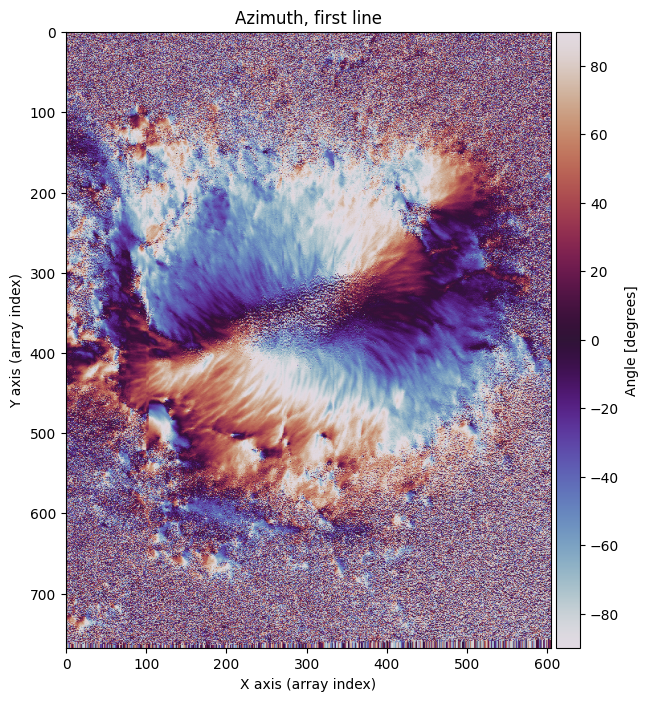

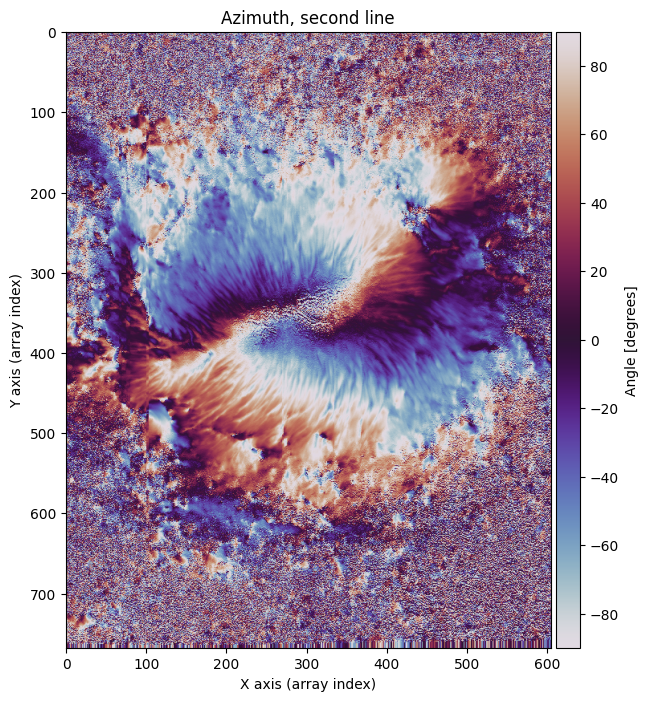

(<Figure size 800x800 with 2 Axes>,
 <Axes: title={'center': 'Azimuth, second line'}, xlabel='X axis (array index)', ylabel='Y axis (array index)'>)

In [24]:
plot_angle_gradient(chi_1, title='Azimuth, first line')
plot_angle_gradient(chi_2, title='Azimuth, second line')